In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy
import time
import pathlib
import random
import IPython.display as display

env: CUDA_VISIBLE_DEVICES=0


In [2]:
batch_size = 100
SAMPLE_COL = 8
SAMPLE_ROW = 8
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW
IMG_H = 128
IMG_W = 128
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)
Z_DIM = 128
BUF = 40000
W_EPOCH = 500
BZ = (batch_size, Z_DIM)
#WClipLo = -0.01
#WClipHi = 0.01
IW_LR=1e-4

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 10000)])

In [4]:
run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)

In [5]:
data_root = pathlib.Path('./C1-P1_Train_A/')
all_image_paths = list(data_root.glob('*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths=sorted(all_image_paths)
image_count = len(all_image_paths)
all_image_paths.pop(0)

'C1-P1_Train_A/.ipynb_checkpoints'

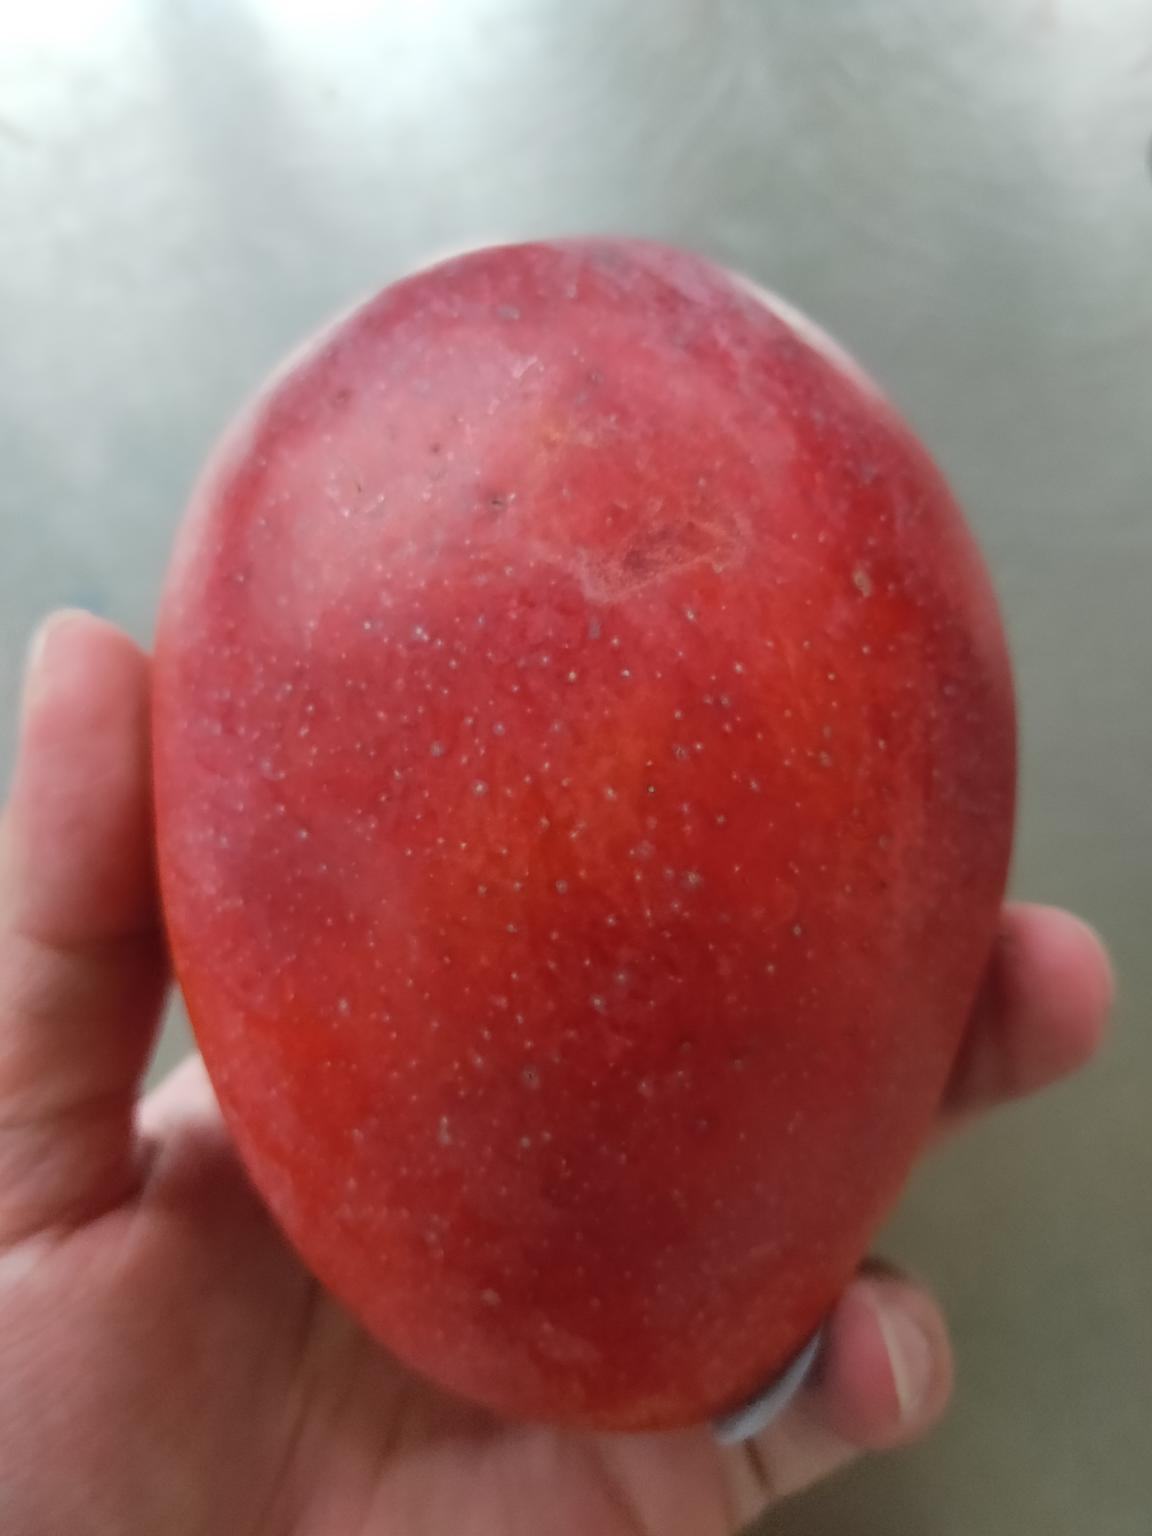

C1-P1_Train_A/05409.jpg


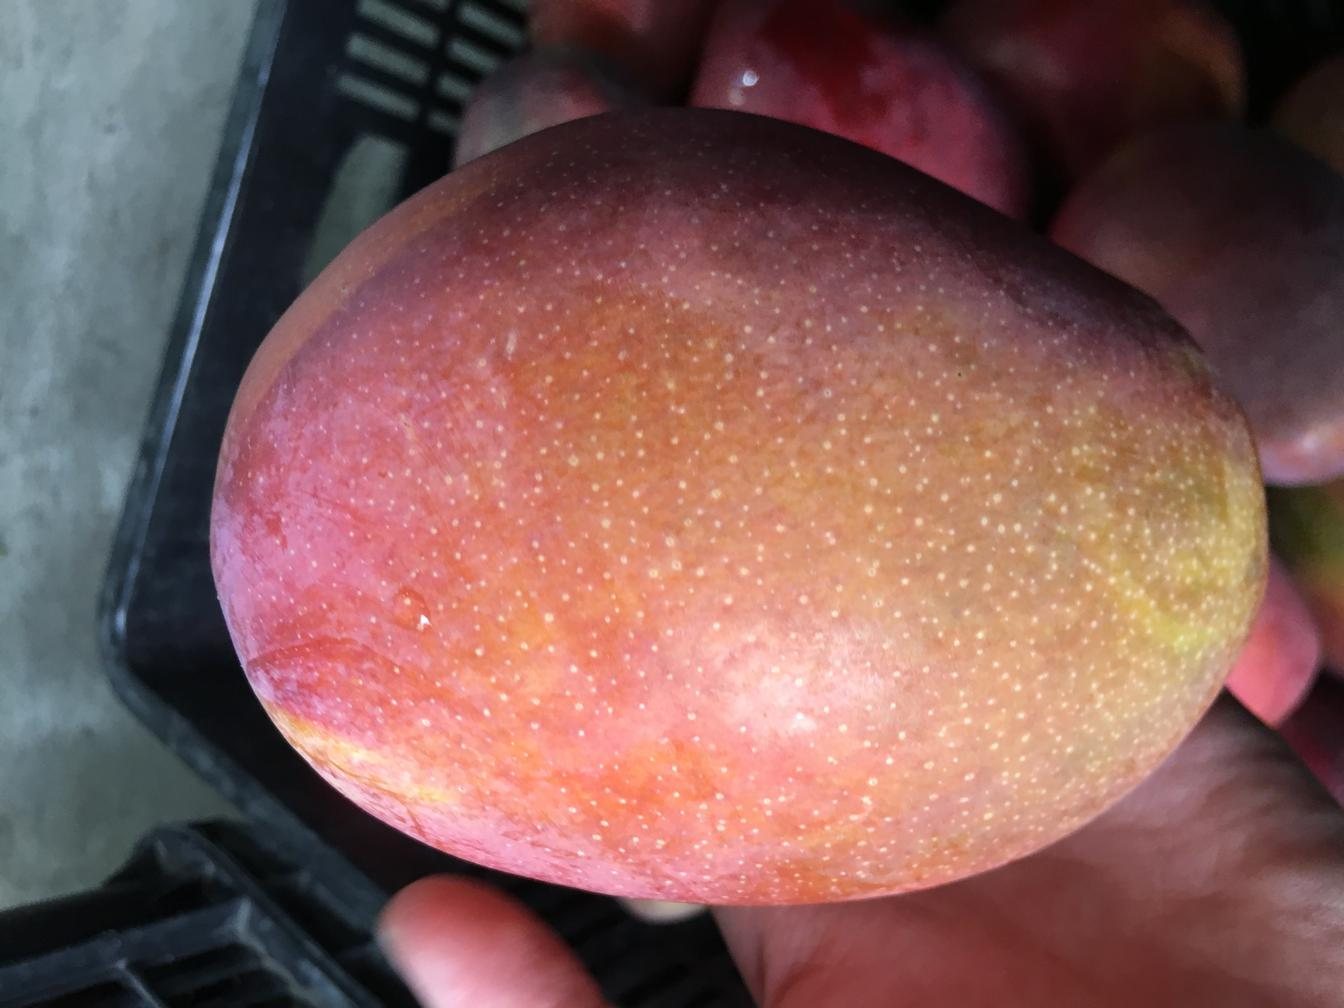

C1-P1_Train_A/05057.jpg


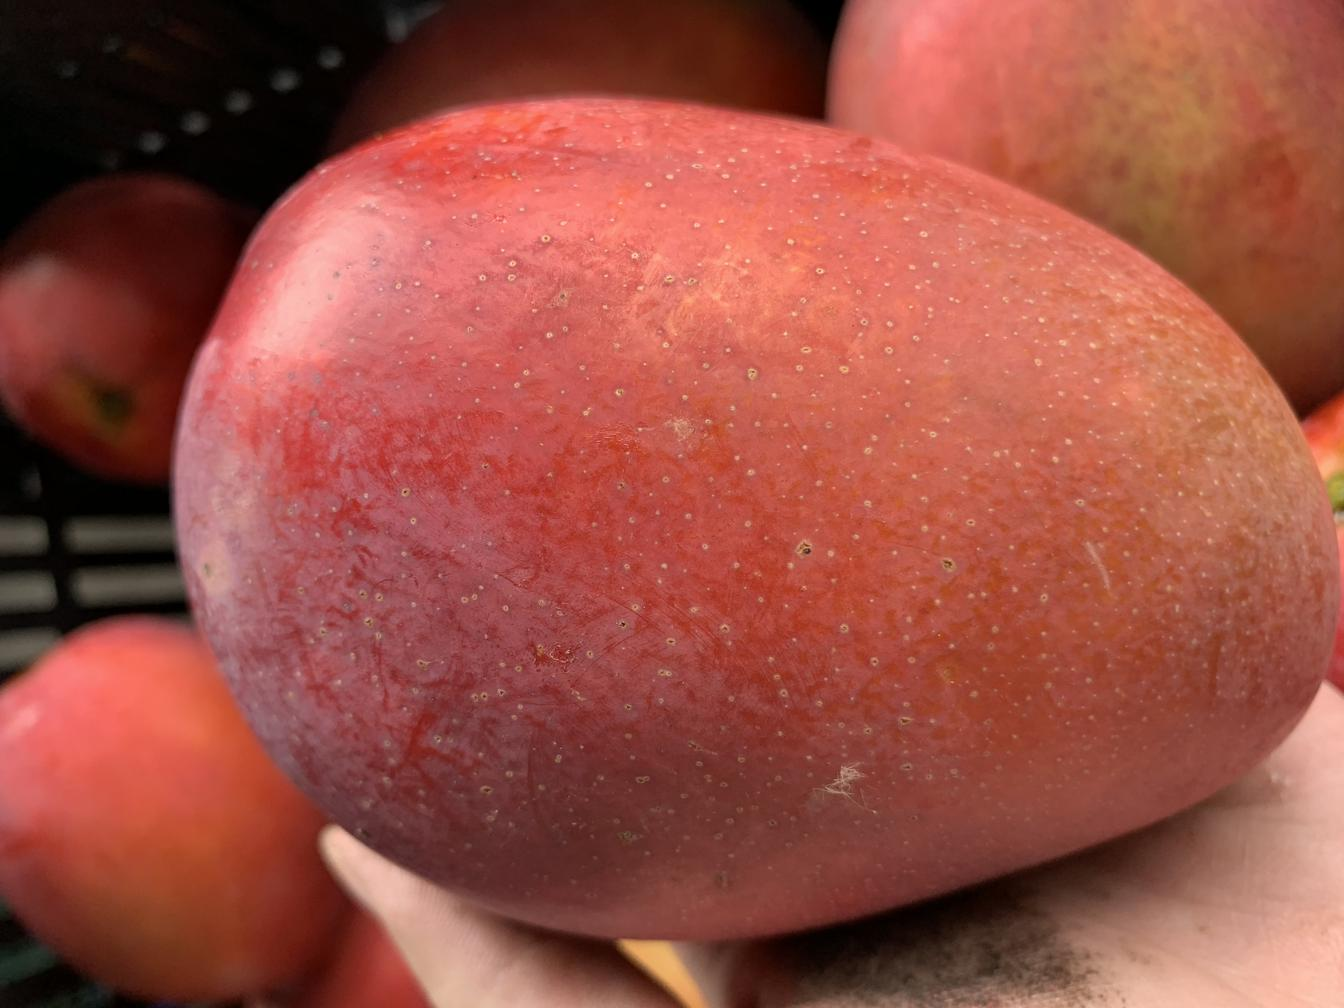

C1-P1_Train_A/02356.jpg


In [6]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path)

In [7]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=IMG_C)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (IMG_H, IMG_W))
    return img

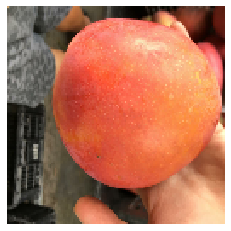

In [8]:
#load_image test
img_test=load_image('C1-P1_Train_A/00504.jpg')
plt.imshow(img_test)
plt.axis("off")
#plt.title("Epoch %d" % ep)
plt.show()

In [9]:
dataset_list = tf.data.Dataset.from_tensor_slices(all_image_paths)
dsTrain = dataset_list.map(load_image).shuffle(BUF).batch(batch_size, True)

In [10]:
dsTrain

<BatchDataset shapes: (100, 128, 128, 3), types: tf.float32>

In [11]:
#(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

#iTrain = train_images.reshape(-1, 28, 28, 1).astype(np.float32)

# Normalizing the images to the range of [0., 1.]
#iTrain = iTrain / 255.0

#dsTrain = tf.data.Dataset.from_tensor_slices(iTrain).shuffle(BUF).batch(batch_size, True)

 #Utility function
def utPuzzle(imgs, row, col, path = None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

In [12]:
#DCG, DCD = GAN(IMG_SHAPE, Z_DIM)
sp = IMG_SHAPE
zd = Z_DIM
xh, xw, xc = sp
zh = xh // 4 #28/4
zw = xw // 4


In [13]:
def GAN(sp, zd):
    # Shape
    xh, xw, xc = sp#64,64,1
    zh = xh // 4 #7
    zw = xw // 4 #7
    
    # Model
    return keras.Sequential([
        keras.layers.Dense(units  =  1024, input_shape = (zd,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8),#7*7*(2**8=256)
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = sp,
        ),
        keras.layers.LeakyReLU(),
        #keras.layers.Dropout(0.3),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        #keras.layers.Dropout(0.3),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [14]:
WG, WD = GAN(IMG_SHAPE, Z_DIM)

In [15]:
WG.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              132096    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 262144)            268697600 
_________________________________________________________________
batch_normalization_1 (Batch (None, 262144)            1048576   
_________________________________________________________________
re_lu_1 (ReLU)               (None, 262144)            0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 256)       0

In [16]:
WD.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        2432      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       102528    
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)             

In [17]:
opg = keras.optimizers.Adam(learning_rate=IW_LR,beta_1=0.,beta_2=0.9)
opd = keras.optimizers.Adam(learning_rate=IW_LR,beta_1=0.,beta_2=0.9)

In [18]:
@tf.function
def WGTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpg:
        c0 = WG(z, training = True)

        z1 = WD(c1, training = True)
        z0 = WD(c0, training = True)

        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)

    gg = tpg.gradient(lg, WG.trainable_variables)

    opg.apply_gradients(zip(gg, WG.trainable_variables))
    
    return lg, ld

@tf.function
def WDTrain(c1):
    #print(c1.shape)
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpd:
        c0 = WG(z, training = True)

        z1 = WD(c1, training = True)
        z0 = WD(c0, training = True)

        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)
                
        epsilon = tf.random.uniform([batch_size, 1, 1, 1], 0., 1.)
        diff = c0-c1
        inter = c1+(epsilon*diff)
        with tf.GradientTape() as t:
            t.watch(inter)
            pred = WD(inter, training=True)
        grad = t.gradient(pred, [inter])[0]
        norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
        gp = tf.reduce_mean((norm-1.) **2)
        
        grad_penalty_weight = 10.0
        ld += grad_penalty_weight*gp

    gd = tpd.gradient(ld, WD.trainable_variables)
    opd.apply_gradients(zip(gd, WD.trainable_variables))
    #for v in WD.trainable_variables : v.assign(tf.clip_by_value(v, WClipLo, WClipHi))
    return lg, ld

WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

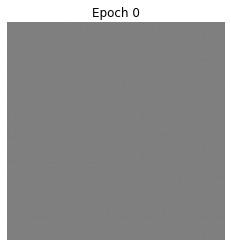

Time taken 39.66080164909363 sec

Time taken 30.538751125335693 sec

Time taken 29.555951356887817 sec

Time taken 29.211451292037964 sec

Time taken 29.107117414474487 sec

Time taken 28.80102777481079 sec

Time taken 29.21648144721985 sec

Time taken 28.726258516311646 sec

Time taken 28.819729566574097 sec

Time taken 28.64503240585327 sec



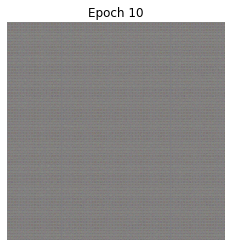

Time taken 28.948843002319336 sec

Time taken 28.71261191368103 sec

Time taken 29.357837915420532 sec

Time taken 28.595351934432983 sec

Time taken 28.79087233543396 sec

Time taken 28.615936279296875 sec

Time taken 28.727424383163452 sec

Time taken 28.604697227478027 sec

Time taken 29.42186164855957 sec

Time taken 28.565474271774292 sec



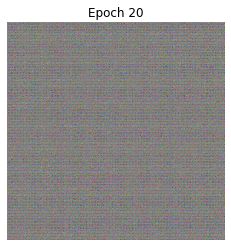

Time taken 28.97248411178589 sec

Time taken 28.606407642364502 sec

Time taken 28.821709871292114 sec

Time taken 28.66847848892212 sec

Time taken 29.470574378967285 sec

Time taken 28.575889587402344 sec

Time taken 28.819523334503174 sec

Time taken 28.62299919128418 sec

Time taken 28.86138606071472 sec

Time taken 28.588721752166748 sec



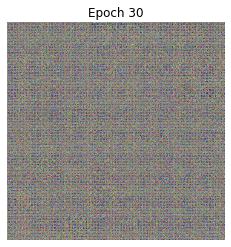

Time taken 29.19247055053711 sec

Time taken 28.56976556777954 sec

Time taken 28.75345206260681 sec

Time taken 28.58485460281372 sec

Time taken 28.850913763046265 sec

Time taken 28.625431537628174 sec

Time taken 29.13662338256836 sec

Time taken 28.81073307991028 sec

Time taken 28.78806781768799 sec

Time taken 28.622339963912964 sec



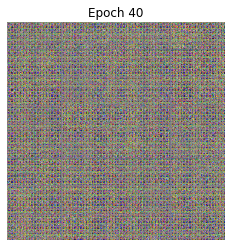

Time taken 28.869089365005493 sec

Time taken 28.66812491416931 sec

Time taken 29.115936756134033 sec

Time taken 28.989330530166626 sec

Time taken 28.75114154815674 sec

Time taken 28.652933597564697 sec

Time taken 28.775651931762695 sec

Time taken 28.685418128967285 sec

Time taken 29.020475387573242 sec

Time taken 29.215503454208374 sec



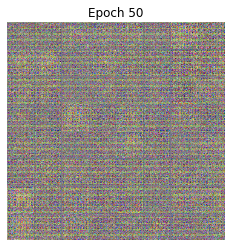

Time taken 28.91571354866028 sec

Time taken 28.714341163635254 sec

Time taken 28.764560222625732 sec

Time taken 28.72031593322754 sec

Time taken 29.129064559936523 sec

Time taken 28.620187759399414 sec

Time taken 28.787832736968994 sec

Time taken 28.615118980407715 sec

Time taken 28.84788966178894 sec

Time taken 28.626450538635254 sec



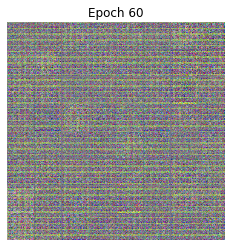

Time taken 29.214771032333374 sec

Time taken 28.60668444633484 sec

Time taken 28.945310831069946 sec

Time taken 28.604301929473877 sec

Time taken 28.86356806755066 sec

Time taken 28.594732761383057 sec

Time taken 29.113368272781372 sec

Time taken 28.620086193084717 sec

Time taken 29.17993998527527 sec

Time taken 28.617435693740845 sec



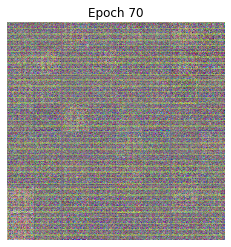

Time taken 28.964434385299683 sec

Time taken 28.648097276687622 sec

Time taken 29.114294052124023 sec

Time taken 28.64221954345703 sec

Time taken 29.20700693130493 sec

Time taken 28.61874794960022 sec

Time taken 28.81580638885498 sec

Time taken 28.609907150268555 sec

Time taken 29.11730122566223 sec

Time taken 28.62375497817993 sec



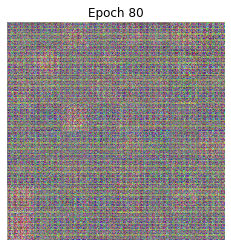

Time taken 28.939953327178955 sec

Time taken 28.60769510269165 sec

Time taken 28.8158175945282 sec

Time taken 28.647216081619263 sec

Time taken 29.141223907470703 sec

Time taken 28.60583472251892 sec

Time taken 28.877095222473145 sec

Time taken 28.71525287628174 sec

Time taken 28.779006958007812 sec

Time taken 28.623177528381348 sec



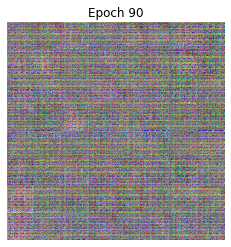

Time taken 29.206366539001465 sec

Time taken 28.665050983428955 sec

Time taken 28.837250232696533 sec

Time taken 29.065210580825806 sec

Time taken 28.771871328353882 sec

Time taken 28.70606803894043 sec

Time taken 29.11188006401062 sec

Time taken 28.835242986679077 sec

Time taken 28.805534601211548 sec

Time taken 29.064531803131104 sec



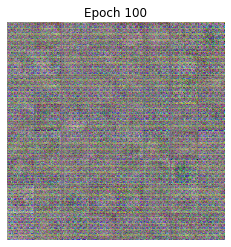

Time taken 29.087085962295532 sec

Time taken 28.664971828460693 sec

Time taken 29.13161873817444 sec

Time taken 28.662853002548218 sec

Time taken 28.855870723724365 sec

Time taken 28.75089168548584 sec

Time taken 28.842726707458496 sec

Time taken 28.623788118362427 sec

Time taken 29.258015871047974 sec

Time taken 28.81622338294983 sec



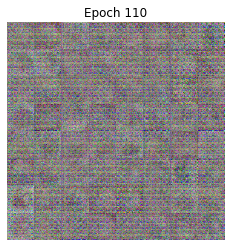

Time taken 28.98878812789917 sec

Time taken 28.675196647644043 sec

Time taken 28.812504768371582 sec

Time taken 28.840866088867188 sec

Time taken 29.169880867004395 sec

Time taken 28.659965991973877 sec

Time taken 28.863842487335205 sec

Time taken 28.73560643196106 sec

Time taken 29.216906309127808 sec

Time taken 28.686013221740723 sec



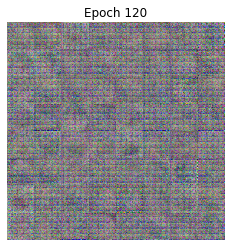

Time taken 29.23758363723755 sec

Time taken 28.91802453994751 sec

Time taken 28.953156232833862 sec

Time taken 28.700992822647095 sec

Time taken 29.268498182296753 sec

Time taken 28.84872317314148 sec

Time taken 29.21345591545105 sec

Time taken 28.652379512786865 sec

Time taken 28.82399320602417 sec

Time taken 28.657564640045166 sec



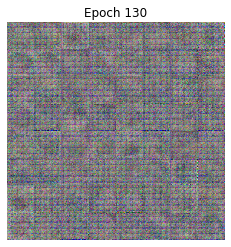

Time taken 28.980708837509155 sec

Time taken 28.848610162734985 sec

Time taken 29.315781116485596 sec

Time taken 28.998011589050293 sec

Time taken 29.0274555683136 sec

Time taken 28.94742250442505 sec

Time taken 28.924516677856445 sec

Time taken 28.9233181476593 sec

Time taken 29.20347785949707 sec

Time taken 28.915196180343628 sec



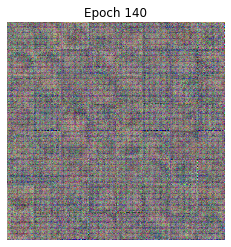

Time taken 29.136596202850342 sec

Time taken 28.98681879043579 sec

Time taken 29.056947708129883 sec

Time taken 29.117395401000977 sec

Time taken 29.25875997543335 sec

Time taken 28.720593452453613 sec

Time taken 29.09158730506897 sec

Time taken 28.954270839691162 sec

Time taken 28.99950122833252 sec

Time taken 29.19711709022522 sec



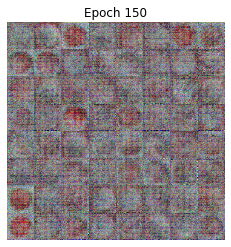

Time taken 29.349916696548462 sec

Time taken 28.91183352470398 sec

Time taken 28.876627922058105 sec

Time taken 28.834293842315674 sec

Time taken 28.915124654769897 sec

Time taken 29.257026433944702 sec

Time taken 29.257328510284424 sec

Time taken 29.010114431381226 sec

Time taken 29.0140962600708 sec

Time taken 28.710748434066772 sec



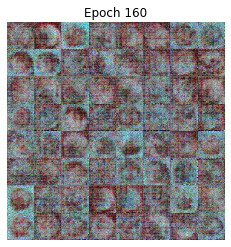

Time taken 29.130170106887817 sec

Time taken 28.938446521759033 sec

Time taken 29.265880823135376 sec

Time taken 29.009267568588257 sec

Time taken 28.916941165924072 sec

Time taken 28.697582483291626 sec

Time taken 28.83519673347473 sec

Time taken 28.995359897613525 sec

Time taken 29.18458580970764 sec

Time taken 28.688826084136963 sec



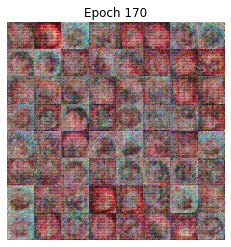

Time taken 29.09071373939514 sec

Time taken 28.804624557495117 sec

Time taken 28.996631622314453 sec

Time taken 28.705894231796265 sec

Time taken 29.514129877090454 sec

Time taken 28.72494864463806 sec

Time taken 28.913898468017578 sec

Time taken 28.737487316131592 sec

Time taken 28.90754532814026 sec

Time taken 28.701641082763672 sec



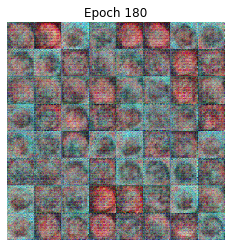

Time taken 29.798824071884155 sec

Time taken 28.890947103500366 sec

Time taken 28.973342895507812 sec

Time taken 28.676146030426025 sec

Time taken 28.968764305114746 sec

Time taken 28.705161571502686 sec

Time taken 29.76437783241272 sec

Time taken 28.692490100860596 sec

Time taken 28.996739387512207 sec

Time taken 28.68546772003174 sec



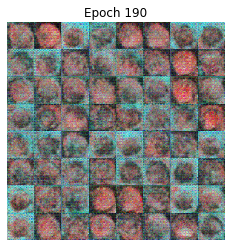

Time taken 28.979462146759033 sec

Time taken 28.67435574531555 sec

Time taken 29.08831787109375 sec

Time taken 28.608218669891357 sec

Time taken 28.84032130241394 sec

Time taken 28.66265559196472 sec

Time taken 28.787254571914673 sec

Time taken 28.716962814331055 sec

Time taken 29.0980224609375 sec

Time taken 28.579652309417725 sec



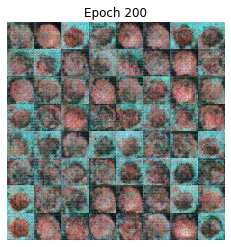

Time taken 28.897011280059814 sec

Time taken 28.885833263397217 sec

Time taken 28.780068397521973 sec

Time taken 28.616633415222168 sec

Time taken 29.087353229522705 sec

Time taken 29.02118992805481 sec

Time taken 28.748069286346436 sec

Time taken 28.642240047454834 sec

Time taken 28.8777277469635 sec

Time taken 28.722241640090942 sec



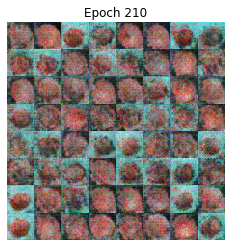

Time taken 29.228148698806763 sec

Time taken 29.076671838760376 sec

Time taken 28.804056882858276 sec

Time taken 28.678404092788696 sec

Time taken 28.77755331993103 sec

Time taken 28.664764404296875 sec

Time taken 29.038280725479126 sec

Time taken 28.64911723136902 sec

Time taken 28.87936019897461 sec

Time taken 28.683851718902588 sec



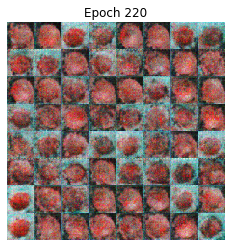

Time taken 28.930572032928467 sec

Time taken 28.618912935256958 sec

Time taken 29.195197343826294 sec

Time taken 28.339515447616577 sec

Time taken 28.506615161895752 sec

Time taken 28.36894130706787 sec

Time taken 28.514514923095703 sec

Time taken 28.3684720993042 sec

Time taken 28.812258005142212 sec

Time taken 28.50942873954773 sec



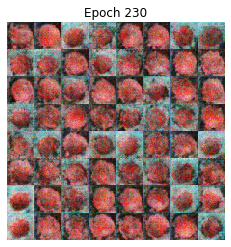

Time taken 29.11237406730652 sec

Time taken 28.461857318878174 sec

Time taken 28.80914568901062 sec

Time taken 28.638233184814453 sec

Time taken 29.133090257644653 sec

Time taken 28.668925285339355 sec

Time taken 29.285612106323242 sec

Time taken 28.612430095672607 sec

Time taken 28.819265365600586 sec

Time taken 28.708218336105347 sec



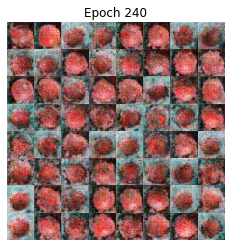

Time taken 29.30106210708618 sec

Time taken 28.596635580062866 sec

Time taken 28.830709218978882 sec

Time taken 28.653902292251587 sec

Time taken 28.77266788482666 sec

Time taken 28.695159196853638 sec

Time taken 29.07044291496277 sec



In [ ]:
wlg = [None] * W_EPOCH
wld = [None] * W_EPOCH
wsp = [None] * W_EPOCH
rsTrain = float(batch_size) / float(image_count)
ctr = 0
for ep in range(W_EPOCH):
    start = time.time()
    lgt = 0.0
    ldt = 0.0
    for c1 in dsTrain:
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    out = WG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "test3-2/w_%04d.png" % ep
    )
    wsp[ep] = img
    if ep % 10 == 0:
        plt.imshow(img)
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()
    print ('Time taken {} sec\n'.format(time.time() - start))

In [ ]:
utMakeGif(np.array(wsp), "test3-2/iwgan-3.gif", duration = 2)

In [ ]:
plt.plot(range(W_EPOCH), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(W_EPOCH), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN Training Loss")
plt.show()

#report

1.建立dataset，使用tf.data.Dataset先資料夾內所有圖片的名字存到dataset中，再用map function，
使用 load_image 進行資料預處理，建立圖片dataset。
    
2.dsTrain = dataset_list.map(load_image).shuffle(BUF).batch(batch_size, True)
將dataset shuffle 和因為演算法中的batch size 的foor loop，所以對dataset做batch化。

3.將WGAN的optimizers改成Adam根據演算法中的調整參數
opg = keras.optimizers.Adam(learning_rate=IW_LR,beta_1=0.,beta_2=0.9)
opd = keras.optimizers.Adam(learning_rate=IW_LR,beta_1=0.,beta_2=0.9)

4.在WDTrain修改loss算法和增加gradient penalty

In [ ]:
WG.save('h5/'+'WG'+str(ep)+'.h5')
WD.save('h5/'+'WD'+str(ep)+'.h5')